### Import modules and verify they work? 

In [47]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm
import gc

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# pip install ewatercycle-HBV

In [4]:
import ewatercycle_HBV

In [5]:
ewatercycle_HBV.__version__

'1.8.3'

In [6]:
# pip uninstall ewatercycle-DA -y

In [7]:
# pip install --upgrade git+https://github.com/Daafip/eWaterCycle-DA@dev

In [8]:
from ewatercycle_DA import DA

#### set up paths

In [25]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"

#### add parameter info

In [54]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [11]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"
HRU_id = 2479155
alpha = 1.2626

In [12]:
from ewatercycle.forcing import sources 

In [14]:
test_forcing = ewatercycle.forcing.sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'test_forcing.txt',
                          test_data_bool=True
                          )

#### Can also run locally

In [15]:
ewatercycle.models.sources

ModelSources[
    "HBV",
    "HBVLocal",
    "LeakyBucket",
    "Lorenz",
    "MarrmotM01",
    "MarrmotM14",
    "ParallelisationSleep"
]

In [16]:
from ewatercycle.models import HBVLocal 

In [44]:
n_particles = 10
model_name = "HBVLocal"
sigma_w = 0.45
sigma_pp = 0.003
sigma_ps = 2
sigma_tuple = sigma_pp, sigma_ps, sigma_w
assimilate_window = 3

In [45]:
def H(Z):
    """Operator function extracts observable state from the state vector"""
    len_Z = 15
    if len(Z) == len_Z:
        return Z[-1] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be {len_Z} but is {len(Z)}")

In [48]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

# initial values
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                            'initial_storage':','.join([str(s) for s in s_0]),
                             })


# not required as of ewatercycle-HBV==1.8.2
# ensemble.loaded_models.update({'HBVLocal': HBVLocal})

# this initializes the models for all ensemble members. 
ensemble.initialize(model_name=[model_name]*n_particles,
                    forcing=[test_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

# create a reference model
ref_model = ensemble.ensemble_list[0].model

# load observations
ds_obs_dir = observations_path / f'Q_test.nc'
if not ds_obs_dir.exists():
    ds = xr.open_dataset(forcing_path / test_forcing.pr)
    ds_obs = ds[['Q']].copy()
    ds_obs.to_netcdf(ds_obs_dir)
    ds.close()
else:
    ds_obs = xr.open_dataset(ds_obs_dir)

# set up hyperparameters
sigma_pp , sigma_ps, sigma_w = sigma_tuple
lst_like_sigma = [sigma_pp] * 9 + [sigma_ps] * 5 + [0]
hyper_parameters = {'like_sigma_weights' : sigma_w,
                    'like_sigma_state_vector' : lst_like_sigma,
                   }

ensemble.initialize_da_method(ensemble_method_name = "PF", 
                              hyper_parameters=hyper_parameters,                           
                              state_vector_variables = "all", # the next three are keyword arguments but are needed. 
                              observation_path = ds_obs_dir,
                              observed_variable_name = "Q",
                              measurement_operator = H, 
                           
                            )
# extract units for later
state_vector_variables = ensemble.ensemble_list[0].variable_names
units = {}
for var in state_vector_variables:
    units.update({var : ref_model.bmi.get_var_units(var)})
    
## run!
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
time = []
lst_state_vector = []
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    # update every 3 steps 
    if i % assimilate_window == 0: 
        assimilate = True 
    else:
        assimilate = False
    ensemble.update(assimilate=assimilate)

    state_vector = ensemble.get_state_vector()
    min = state_vector.T.min(axis=1)
    max = state_vector.T.max(axis=1)
    mean = state_vector.T.mean(axis=1)
    summarised_state_vector = np.array([min, max, mean])
    lst_state_vector.append(summarised_state_vector)
    del state_vector, min, max, mean, summarised_state_vector
    gc.collect()

ensemble.finalize()

# post process
state_vector_arr = np.array(lst_state_vector)

100%|███████████████████████████████████████████████████████████████████████████████| 1126/1126 [02:58<00:00,  6.30it/s]


In [56]:
data_vars = {}
for i, name in enumerate(param_names + stor_names + ["Q"]):
    storage_terms_i = xr.DataArray(state_vector_arr[:, :, i].T,
                                   name=name,
                                   dims=["summary_stat", "time"],
                                   coords=[['min','max','mean'],
                                           time],
                                   attrs={
                                       "title": f"HBV storage terms data over time for {n_particles} particles ",
                                       "history": f"Storage term results from ewatercycle_HBV.model",
                                       "description": "Moddeled values",
                                       "units": f"{units[name]}"})
    data_vars[name] = storage_terms_i

ds_combined = xr.Dataset(data_vars,
                         attrs={
                             "title": f"HBV storage & parameter terms data over time for {n_particles} particles ",
                             "history": f"Storage term results from ewatercycle_HBV.model",
                             "sigma_pp": sigma_pp,
                             "sigma_ps": sigma_ps,
                             "sigma_w": sigma_w,
                             "assimilate_window": assimilate_window,
                             "n_particles": n_particles,
                             "HRU_id": HRU_id,
                              }
                         )

ds_observations = ds_obs['Q'].sel(time=time)
ds_observations = ds_obs['Q'].sel(time=time)
ds_obs.close()
ds_combined['Q_obs'] = ds_observations

In [57]:
ds_combined

<xarray.Dataset>
Dimensions:       (summary_stat: 3, time: 1126)
Coordinates:
  * summary_stat  (summary_stat) <U4 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 1997-08-01 1997-08-02 ... 2000-08-30
Data variables: (12/16)
    Imax          (summary_stat, time) float64 0.1048 0.1048 0.1048 ... 3.6 3.6
    Ce            (summary_stat, time) float64 0.2479 0.2479 ... 0.572 0.572
    Sumax         (summary_stat, time) float64 237.9 237.9 237.9 ... 481.1 481.1
    Beta          (summary_stat, time) float64 0.6746 0.6746 ... 0.7639 0.7639
    Pmax          (summary_stat, time) float64 0.01942 0.01942 ... 0.03285
    Tlag          (summary_stat, time) float64 3.0 3.0 3.0 3.0 ... 5.0 5.0 5.0
    ...            ...
    Su            (summary_stat, time) float64 99.75 98.0 97.38 ... 165.1 163.5
    Sf            (summary_stat, time) float64 0.01131 0.01129 ... 9.524 8.679
    Ss            (summary_stat, time) float64 4.965 4.93 4.896 ... 1.858 1.854
    Sp            (summary_stat, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Q             (summary_stat, time) float64 0.0004712 0.0004722 ... 0.6748
    Q_obs         (time) float64 ...
Attributes:
    title:              HBV storage & parameter terms data over time for 10 p...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0.003
    sigma_ps:           2
    sigma_w:            0.45
    assimilate_window:  3
    n_particles:        10
    HRU_id:             2479155

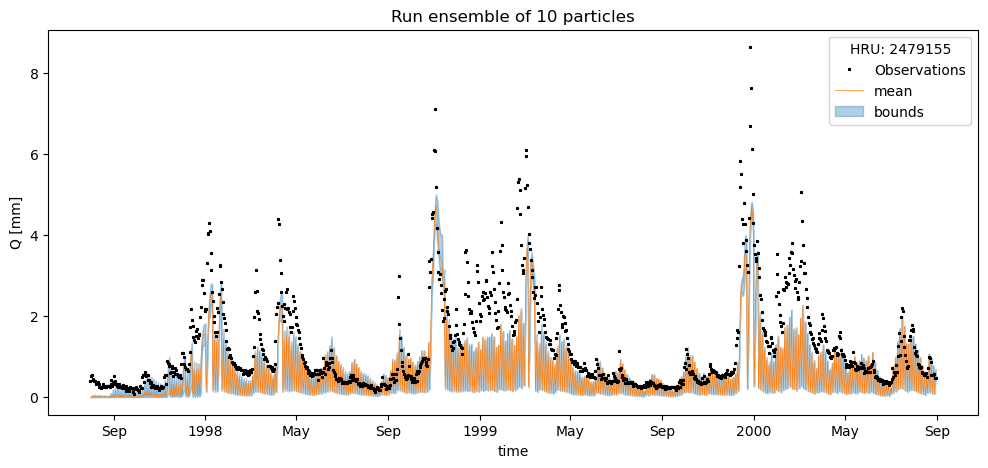

In [66]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean",zorder=-1)

ax.fill_between(ds_combined.time, 
                         ds_combined["Q"].sel(summary_stat="min").values,
                         ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
n_particles = ds_combined.attrs['n_particles']
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");

ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}");#bbox_to_anchor=(1.25,1))
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_hydrograph.png'), bbox_inches="tight",dpi=400)
# plt.close(fig)